# GAN MNIST

In [1]:
import torch
from torch import nn
from torchvision.datasets import MNIST

## Download, Analyze, & Visualize the dataset

### Download

In [2]:
dataset_dir = "../datasets/"

In [3]:
train_dataset = MNIST(root=dataset_dir,
                                 train=True,
                                 download=False)

test_dataset = MNIST(root=dataset_dir,
                            train=False,
                            download=False)

### Analyze

In [4]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../datasets/
    Split: Train

In [5]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../datasets/
    Split: Test

In [6]:
# classes
class_names = train_dataset.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [17]:
# sample
img, label = train_dataset[12]
img, label

(<PIL.Image.Image image mode=L size=28x28>, 3)

### Visualize

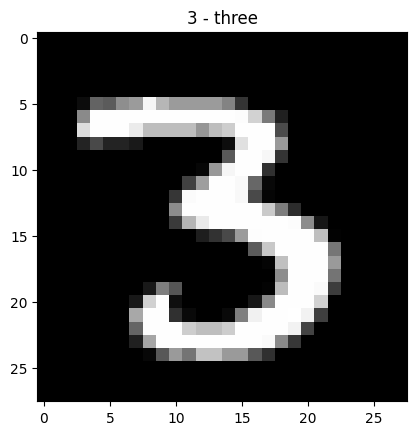

In [18]:
# single sample
import matplotlib.pyplot as plt

plt.imshow(img, cmap='gray')
plt.title(f"{class_names[label]}");

In [19]:
# single sample: fancy visualization
import matplotlib as mpl

def img_pixel_superimpose(img, ax):
    """Expecting gray-scale image"""
    h, w = img.shape
    
    color_map = mpl.colormaps.get_cmap('gray_r')
    ax.imshow(img, cmap='gray')
    for y in range(h):
        for x in range(w):
            color = color_map(img[y][x])
            plt.annotate(text=f"{img[y][x]}", xy=(x,y),
                         horizontalalignment='center',
                         verticalalignment='center',
                         color=color)

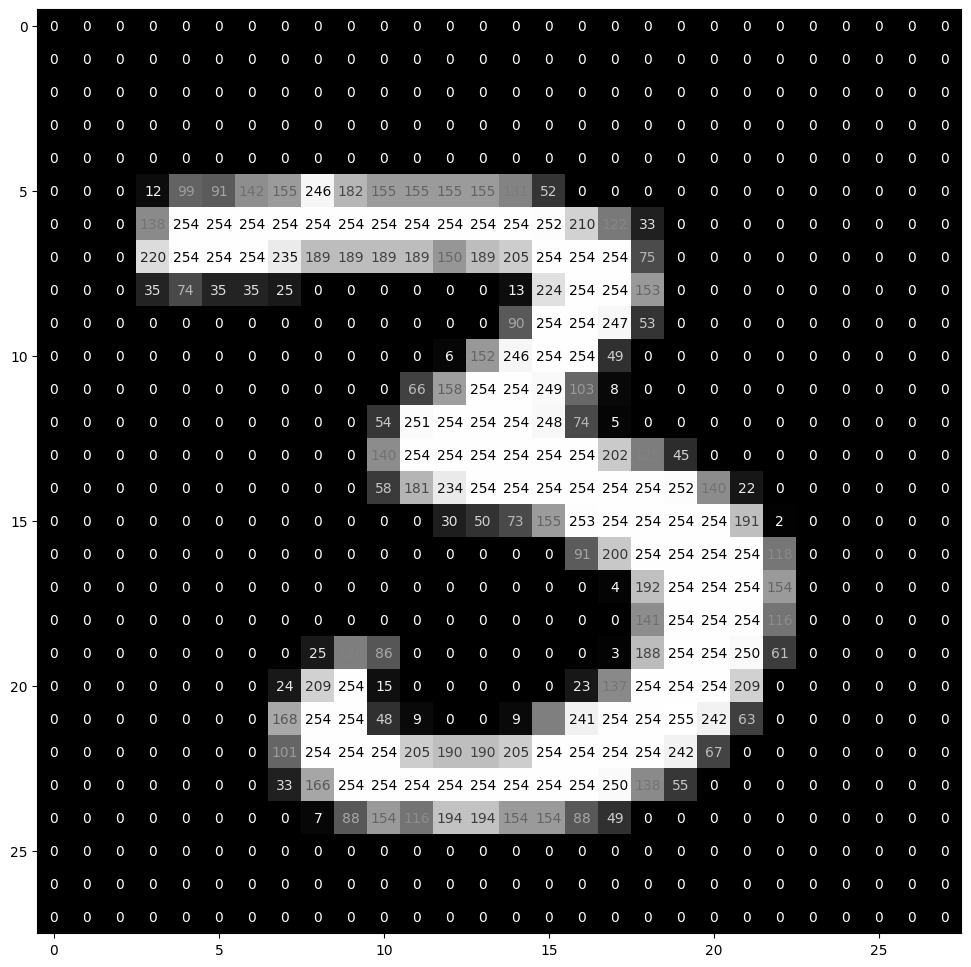

In [20]:
import numpy as np

img_arr = np.array(img)
# print(img_arr.shape)

fig = plt.figure(figsize=(12, 12)) 
ax = fig.add_subplot(1, 1, 1)

img_pixel_superimpose(img_arr, ax)

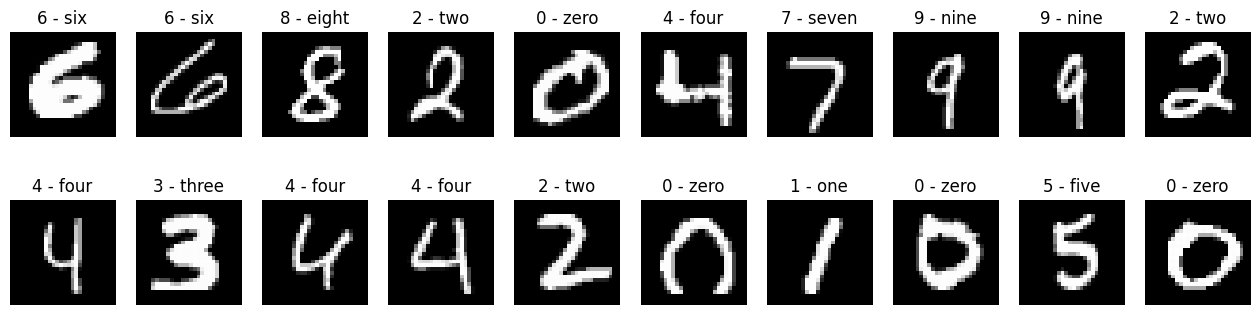

In [11]:
# batch of random samples

torch.manual_seed(42)

fig = plt.figure(figsize=(16, 4))
rows, cols = 2, 10
for i in range(1, ((rows * cols) + 1)):
    rand_idx = torch.randint(0, len(train_dataset), size=[1]).item()
    img, label = train_dataset[rand_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img, cmap='gray')
    plt.title(f"{class_names[label]}")
    plt.axis(False)

### Transform

In [12]:
from torchvision import transforms

In [13]:
transforms_mnist = transforms.Compose([transforms.ToTensor()])
transforms_mnist

Compose(
    ToTensor()
)

In [14]:
train_dataset = MNIST(root=dataset_dir,
                      train=True,
                      download=False,
                      transform=transforms_mnist)

test_dataset = MNIST(root=dataset_dir,
                     train=False,
                     download=True,
                     transform=transforms_mnist)

### Dataloaders

In [15]:
from torch.utils.data import DataLoader

In [16]:
BATCH_SIZE = 32

In [17]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

len(train_dataloader), len(test_dataloader)

(1875, 313)

In [18]:
imgs, labels = next(iter(train_dataloader))
imgs.shape, labels.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## Model

### Generator

In [19]:
import torch
import torch.nn as nn

In [20]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            # Layer 1
            nn.Linear(in_features=latent_dim, out_features=256), 
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # Layer 2
            nn.Linear(in_features=256, out_features=512),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # Layer 3
            nn.Linear(in_features=512, out_features=1024),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # Layer 4
            nn.Linear(in_features=1024, out_features=784),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img

### Discriminator

In [21]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.features = nn.Sequential(
            # Layer 1
            nn.Linear(in_features=784, out_features=1024),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(p=0.3),
            # Layer 2
            nn.Linear(in_features=1024, out_features=512),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(p=0.3),
            # Layer 3
            nn.Linear(in_features=512, out_features=256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(p=0.3),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=256, out_features=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.features(x)
        validity = self.classifier(x)
        return validity

## Loss, Optimizer and Metrics

In [22]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Hyperparameters
latent_dim = 100
channels = 1
epochs = 15
lr = 0.0002
beta1 = 0.5

Device: cuda


In [23]:
# Loss function
adversarial_loss = nn.BCELoss()

In [24]:
# Initialize generator and discriminator
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

In [42]:
from torchinfo import summary

In [44]:
summary(model=generator, input_size=(1, 100))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 784]                  --
├─Sequential: 1-1                        [1, 784]                  --
│    └─Linear: 2-1                       [1, 256]                  25,856
│    └─LeakyReLU: 2-2                    [1, 256]                  --
│    └─Linear: 2-3                       [1, 512]                  131,584
│    └─LeakyReLU: 2-4                    [1, 512]                  --
│    └─Linear: 2-5                       [1, 1024]                 525,312
│    └─LeakyReLU: 2-6                    [1, 1024]                 --
│    └─Linear: 2-7                       [1, 784]                  803,600
│    └─Tanh: 2-8                         [1, 784]                  --
Total params: 1,486,352
Trainable params: 1,486,352
Non-trainable params: 0
Total mult-adds (M): 1.49
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 5.95
Estimated Total Size 

In [45]:
summary(model=discriminator, input_size=(1, 784))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─Sequential: 1-1                        [1, 256]                  --
│    └─Linear: 2-1                       [1, 1024]                 803,840
│    └─LeakyReLU: 2-2                    [1, 1024]                 --
│    └─Dropout: 2-3                      [1, 1024]                 --
│    └─Linear: 2-4                       [1, 512]                  524,800
│    └─LeakyReLU: 2-5                    [1, 512]                  --
│    └─Dropout: 2-6                      [1, 512]                  --
│    └─Linear: 2-7                       [1, 256]                  131,328
│    └─LeakyReLU: 2-8                    [1, 256]                  --
│    └─Dropout: 2-9                      [1, 256]                  --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Linear: 2-10                      [1, 1]                    257

## Training

In [25]:
# Training loop
for epoch in range(epochs):
    for (imgs, _) in train_dataloader:
        
        # Adversarial ground truths
        valid = torch.ones((imgs.size(0), 1)).to(device)
        fake = torch.zeros((imgs.size(0), 1)).to(device)
        
        # Configure input
        imgs = imgs.reshape(BATCH_SIZE, -1)
        real_imgs = imgs.to(device)
        z = torch.randn((BATCH_SIZE, latent_dim)).to(device)
        
        # Train Generator
        optimizer_G.zero_grad()
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    # Print loss
    print(f"EPOCH: {epoch} | D_Loss: {d_loss.item():.5f} | G_Loss: {g_loss.item():.5f}")

EPOCH: 0 | D_Loss: 0.20800 | G_Loss: 2.03326
EPOCH: 1 | D_Loss: 0.13760 | G_Loss: 2.43223
EPOCH: 2 | D_Loss: 0.18710 | G_Loss: 1.88078
EPOCH: 3 | D_Loss: 0.28621 | G_Loss: 2.27782
EPOCH: 4 | D_Loss: 0.30345 | G_Loss: 1.85866
EPOCH: 5 | D_Loss: 0.22708 | G_Loss: 2.75244
EPOCH: 6 | D_Loss: 0.18203 | G_Loss: 2.46544
EPOCH: 7 | D_Loss: 0.17965 | G_Loss: 2.70058
EPOCH: 8 | D_Loss: 0.20400 | G_Loss: 3.02450
EPOCH: 9 | D_Loss: 0.30482 | G_Loss: 2.21477
EPOCH: 10 | D_Loss: 0.23023 | G_Loss: 3.11826
EPOCH: 11 | D_Loss: 0.15208 | G_Loss: 2.50172
EPOCH: 12 | D_Loss: 0.37272 | G_Loss: 3.23239
EPOCH: 13 | D_Loss: 0.21962 | G_Loss: 2.43643
EPOCH: 14 | D_Loss: 0.24198 | G_Loss: 2.08563


## Save the model

In [26]:
import os

model_save_path = "./models/"
model_name = f"gan_mnist_e{epochs}.pt"

In [27]:
torch.save({"generator_state_dict": generator.state_dict(),
            "discriminator_state_dict": discriminator.state_dict()},
           os.path.join(model_save_path, model_name))

## Load the model

In [28]:
model_trained = torch.load(os.path.join(model_save_path, model_name))

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [30]:
latent_dim = 100
generator_loaded = Generator(latent_dim=latent_dim)
generator_loaded.load_state_dict(model_trained["generator_state_dict"])

<All keys matched successfully>

In [31]:
generator_loaded = generator_loaded.to(device);

## Inferences

In [32]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

### Single

In [46]:
noise_test = torch.randn(latent_dim)
noise_test.unsqueeze_(dim=0)
print(noise_test.shape)
noise_test = noise_test.to(device)

torch.Size([1, 100])


In [34]:
generator_loaded.eval()

with torch.inference_mode():
    gan_img_test = generator_loaded(noise_test)
    
gan_img_test.shape

torch.Size([1, 784])

In [35]:
gan_img_test = gan_img_test.squeeze().reshape(28, 28).to('cpu').detach().numpy()

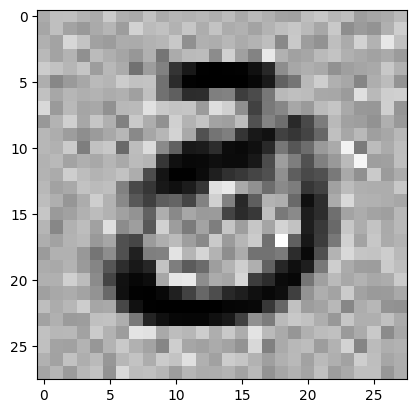

In [36]:
import matplotlib.pyplot as plt

plt.imshow(gan_img_test, cmap='gray_r')

### Multiple

In [37]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [38]:
examples = 100
latent_dim = 100

noise_inputs = torch.randn(examples, latent_dim)
noise_inputs.shape

torch.Size([100, 100])

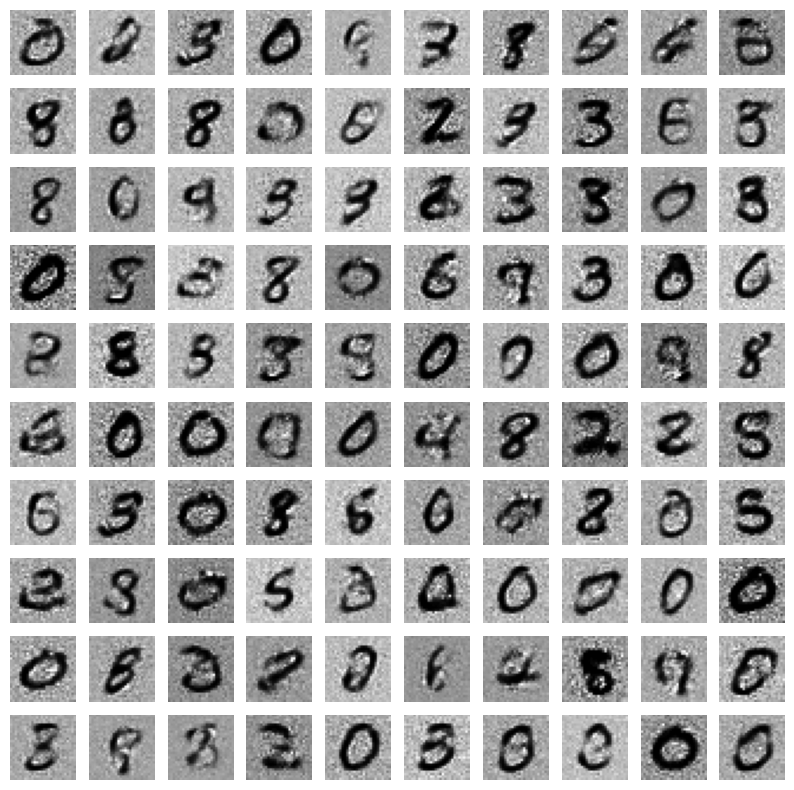

In [47]:
generator_loaded.eval()

rows = 10
cols = 10

fig = plt.figure(figsize=(10, 10))
for i in range(1, (rows * cols) + 1):
    noise_input = noise_inputs[i-1]
    noise_input = noise_input.unsqueeze_(dim=0).to(device)
    with torch.inference_mode():
        gan_output = generator_loaded(noise_input)
    gan_output = gan_output.cpu().detach().numpy().reshape(28, 28)
    fig.add_subplot(rows, cols, i)
    plt.imshow(gan_output, cmap='gray_r')
    plt.axis(False)